In [1]:
%load_ext autoreload
%autoreload 2
import os
# Set environment variables
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
# from jax import config
# config.update('jax_enable_x64', True)

# Check JAX configuration
devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())


from model import *
from model import EF, train_model
import jax
import optax
import e3x

from dcmnet.analysis import create_model_and_params
from dcmnet.data import prepare_batches, prepare_datasets
import numpy as np

[CudaDevice(id=0)]
gpu
[CudaDevice(id=0)]


<Figure size 100x100 with 0 Axes>

In [2]:
data_key, train_key = jax.random.split(
    jax.random.PRNGKey(43), 2)

2024-11-28 11:27:57.129905: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
files = ["/pchem-data/meuwly/boittier/home/ini.to.dioxi.npz"]

In [38]:
NATOMS = 8

In [65]:
train_data, valid_data = prepare_datasets(data_key, 7732-1000, 1000,
                                          files, 
                                          clip_esp=False, natoms=NATOMS, clean=False)

shape (7732, 8, 3) not failed [   0    1    2 ... 7729 7730 7731]
dataR (7732, 8, 3)
D (7732, 3)
Q 1 (7732,) 7732
Q (7732,)
R (7732, 8, 3)
(7732, 8, 3)
['R', 'Z', 'F', 'E', 'N', 'D', 'Q']
7732
0 R 7732 (7732, 8, 3)
1 Z 7732 (7732, 8)
2 F 7732 (7732, 8, 3)
3 E 7732 (7732, 1)
4 N 7732 (7732, 1)
5 D 7732 (7732, 3)
6 Q 7732 (7732,)


In [66]:
N = 5500
test_data = {k: v[N:] for k,v in train_data.items()}
train_data = {k: v[:N] for k,v in train_data.items()}


In [67]:
model = EF(
    # attributes
    features = 128,
    max_degree = 0,
    num_iterations = 5,
    num_basis_functions = 64,
    cutoff = 10.0,
    max_atomic_number = 9,
    charges = True,
    natoms=NATOMS,
    total_charge=0,
)
model

EF(
    # attributes
    features = 128
    max_degree = 0
    num_iterations = 5
    num_basis_functions = 64
    cutoff = 10.0
    max_atomic_number = 9
    charges = True
    natoms = 8
    total_charge = 0
)

In [68]:
batch_size = 1

In [69]:
train_batches = prepare_batches(data_key, train_data, batch_size, 
                                data_keys=["Z", "R", "D", "E", "F"], 
                                    num_atoms=NATOMS)
for _ in train_batches[0].keys():
    print(_,train_batches[0][_].shape, train_batches[0][_].dtype)

R (8, 3) float64
Z (8,) int64
F (8, 3) float64
E (1, 1) float64
D (1, 3) float64
dst_idx (56,) int32
src_idx (56,) int32
batch_segments (8,) int32


In [70]:
from model import dipole_calc
train_key

Array([ 518525930, 1584866388], dtype=uint32)

In [79]:
import pandas as pd
params = pd.read_pickle("checkpoints/diox-q3.1.pkl")

_, train_key = jax.random.split(
    jax.random.PRNGKey(train_key[0]), 2)

data_keys = ["R", "Z", "F", "E", "D", "dst_idx", "src_idx", "batch_segments"]
batch_size = 100
params = train_model(
    train_key,
    model,
    train_data,
    valid_data,
    num_epochs=10**6,
    learning_rate=0.0001, 
    # forces_weight=100,
    # charges_weight=10,
    batch_size=batch_size,
    num_atoms=NATOMS,
    data_keys=data_keys,
    restart = params,
    print_freq=1,
    name = "diox-q3.2"
)

best!
epoch:   1				 train:   valid:
    loss		[a.u.]     	   0.098    0.719    0.695
    energy mae		[kcal/mol]	   2.109    0.160
    forces mae		[kcal/mol/Å]	   0.661    0.695
    dipoles mae		[e Å]     	   0.038    0.039
scale: 1.000000 0.000100 LR=0.000100000
best!
epoch:   2				 train:   valid:
    loss		[a.u.]     	   0.044    0.719    0.694
    energy mae		[kcal/mol]	   0.223    0.161
    forces mae		[kcal/mol/Å]	   0.365    0.694
    dipoles mae		[e Å]     	   0.038    0.039
scale: 1.000000 0.000100 LR=0.000100000
epoch:   3				 train:   valid:
    loss		[a.u.]     	   0.044    0.719    0.694
    energy mae		[kcal/mol]	   0.246    0.162
    forces mae		[kcal/mol/Å]	   0.367    0.695
    dipoles mae		[e Å]     	   0.038    0.039
scale: 1.000000 0.000100 LR=0.000100000
epoch:   4				 train:   valid:
    loss		[a.u.]     	   0.044    0.720    0.694
    energy mae		[kcal/mol]	   0.250    0.160
    forces mae		[kcal/mol/Å]	   0.360    0.694
    dipoles mae		[e Å]     	   0.038    0.

KeyboardInterrupt: 

In [17]:
import pandas as pd

params = pd.read_pickle("checkpoints/diox-q3.1.pkl")

batch_size = 500
valid_batches = prepare_batches(data_key, valid_data, batch_size,
                              num_atoms=NATOMS, 
                              data_keys=data_keys)
# @jax.jit
def eval():
    Es, predEs, Fs, predFs, Ds, predDs, charges, outputs = [], [], [], [], [], [], [], []
    for i, batch in enumerate(valid_batches):
      output = model.apply(
        params,
        atomic_numbers=batch['Z'],
        positions=batch['R'],
        dst_idx=batch['dst_idx'],
        src_idx=batch['src_idx'],
        batch_segments=batch['batch_segments'],
        batch_size=batch_size
      )
      Ds.append(batch["D"])
      D = dipole_calc(batch["R"], batch["Z"], output["charges"],batch['batch_segments'],batch_size)
      # print(D,batch["D"])
      predDs.append(D)
      Es.append(batch["E"])
      predEs.append(output["energy"])
      Fs.append(batch["F"])
      predFs.append(output["forces"])
      charges.append(output["charges"])
    
    Es = np.array(Es).flatten()
    predEs = np.array(predEs).flatten()
    Fs = np.array(Fs).flatten()
    predFs = np.array(predFs).flatten()
    Ds = np.array(Ds) #.flatten()
    predDs = np.array(predDs) #.flatten()
    outputs.append(output)
    return Es, predEs, Fs, predFs, Ds, predDs, charges, outputs


Es, predEs, Fs, predFs, Ds, predDs, charges, outputs  = eval()

Es = Es /(ase.units.kcal/ase.units.mol)
predEs = predEs /(ase.units.kcal/ase.units.mol)
Fs = Fs /(ase.units.kcal/ase.units.mol)
predFs = predFs /(ase.units.kcal/ase.units.mol)

In [18]:
np.mean(abs(np.linalg.norm(Ds[:10], axis=-1) - np.linalg.norm(predDs[:10], axis=-1)))

0.37917778557953685

In [19]:
outputs[0]["charges"].flatten().sum()

Array(-5.42929, dtype=float32)

In [337]:
import pickle
with open(f"checkpoints/diox-q.pkl", "wb") as file:
    pickle.dump(params, file)

In [80]:
import io
import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
import py3Dmol

In [81]:
@jax.jit
def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
  return model.apply(params,
    atomic_numbers=atomic_numbers,
    positions=positions,
    dst_idx=dst_idx,
    src_idx=src_idx,
  )


class MessagePassingCalculator(ase_calc.Calculator):
  implemented_properties = ["energy", "forces", "dipole"]

  def calculate(self, atoms, properties, system_changes = ase.calculators.calculator.all_changes):
    ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(atoms))
    output = evaluate_energies_and_forces(
      atomic_numbers=atoms.get_atomic_numbers(),
      positions=atoms.get_positions(),
      dst_idx=dst_idx,
      src_idx=src_idx
    )

    dipole = dipole_calc(atoms.get_positions(), 
                         atoms.get_atomic_numbers(), 
                         output["charges"],
                np.zeros_like(atoms.get_atomic_numbers()),
                1)
    self.results["dipole"] = dipole
    self.results['energy'] = output["energy"].squeeze() #* (ase.units.kcal/ase.units.mol)
    self.results['forces'] = output["forces"] #* (ase.units.kcal/ase.units.mol) #/ase.units.Angstrom

In [134]:
# Initialize atoms object and attach calculator.
i = 0

Natoms = int(train_data['N'][i])
R = train_data['R'][i][:Natoms] - np.mean(train_data['R'][i][:Natoms], axis=0)
# print(R)
atoms = ase.Atoms(train_data['Z'][i][:Natoms], R )
atoms.set_calculator(MessagePassingCalculator())

# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
# Run structure optimization with BFGS.
_ = ase_opt.BFGS(atoms).run(fmax=1e-4)

      Step     Time          Energy          fmax
BFGS:    0 17:01:10      -28.874949        8.991387
BFGS:    1 17:01:10      -30.351427        3.794872
BFGS:    2 17:01:10      -31.204166        2.987164
BFGS:    3 17:01:10      -31.888691        4.374445
BFGS:    4 17:01:10      -32.199921        1.968277
BFGS:    5 17:01:10      -32.583744        1.668741
BFGS:    6 17:01:10      -32.771381        2.352907
BFGS:    7 17:01:10      -32.993984        1.796753
BFGS:    8 17:01:10      -33.128536        0.942363
BFGS:    9 17:01:10      -33.191185        0.683542
BFGS:   10 17:01:10      -33.218536        0.391389
BFGS:   11 17:01:10      -33.230053        0.297994
BFGS:   12 17:01:10      -33.237801        0.285942
BFGS:   13 17:01:10      -33.243168        0.232170
BFGS:   14 17:01:10      -33.244667        0.072719
BFGS:   15 17:01:10      -33.244858        0.038660
BFGS:   16 17:01:10      -33.244926        0.032848
BFGS:   17 17:01:10      -33.245022        0.032372
BFGS:   18 17:

In [97]:
print(atoms.get_dipole_moment())

# Write structure to xyz file.
xyz = io.StringIO()
ase_io.write(xyz, atoms, format='xyz')

# Visualize the structure with py3Dmol.
view = py3Dmol.view()
view.addModel(xyz.getvalue(), 'xyz')
view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
view.show()

[[ 0.00847037 -0.15011704 -0.29754663]]


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [101]:
# Parameters.
temperature = 500
timestep_fs = 0.25
num_steps = 10000_0

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
dipoles = np.zeros((num_steps, 1, 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  dipoles[i]=atoms.get_dipole_moment()
  # Occasionally print progress.q
  if i % 1000 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")

step     0 epot -31.504 ekin  0.457 etot -31.047
step  1000 epot -31.446 ekin  0.399 etot -31.047
step  2000 epot -31.496 ekin  0.450 etot -31.046
step  3000 epot -31.376 ekin  0.333 etot -31.043
step  4000 epot -31.467 ekin  0.423 etot -31.043
step  5000 epot -31.423 ekin  0.382 etot -31.041
step  6000 epot -31.440 ekin  0.398 etot -31.042
step  7000 epot -31.416 ekin  0.376 etot -31.041
step  8000 epot -31.348 ekin  0.308 etot -31.041
step  9000 epot -31.240 ekin  0.199 etot -31.040
step 10000 epot -31.405 ekin  0.364 etot -31.041
step 11000 epot -31.339 ekin  0.298 etot -31.041
step 12000 epot -31.235 ekin  0.196 etot -31.040
step 13000 epot -31.289 ekin  0.250 etot -31.039
step 14000 epot -31.405 ekin  0.367 etot -31.037
step 15000 epot -31.297 ekin  0.260 etot -31.037
step 16000 epot -31.318 ekin  0.283 etot -31.035
step 17000 epot -31.375 ekin  0.341 etot -31.034
step 18000 epot -31.445 ekin  0.411 etot -31.034
step 19000 epot -31.488 ekin  0.454 etot -31.034
step 20000 epot -31.

In [122]:
# view.getModel().setCoordinates(frames[::10], 'array')
# view.animate({'loop': None, 'interval': 0.1})
# view.show()

In [1]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.legend()
plt.grid()
plt.show()
plt.plot(time, total_energy - total_energy.mean(), label='total energy')
plt.legend()
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
plt.grid()

NameError: name 'plt' is not defined

In [2]:
r = dipoles
for i in range(3):
    plt.plot(r[:,0,i])

NameError: name 'dipoles' is not defined

In [106]:
from statsmodels.tsa.stattools import acovf
10**6/1000

1000.0

In [112]:
# Statistics
# Miscellaneous
import ase.units as units
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acovf
import pint
from scipy.signal import find_peaks
from pathlib import Path

ureg = pint.UnitRegistry()

# Constants
c = units._c * ureg("m/s")
c = c.to("cm/s").magnitude
hbar = 5.29 * 10**-12 * ureg("cm^-1 s")
hbar = hbar.magnitude
# beta = 1 / (units.kB * 300 * ureg("K"))
# beta = beta.to("cm^-1").magnitude
# Quantum correction factor qcf
Kb = 3.1668114e-6  # Boltzmann constant in atomic units (Hartree/K)
beta = 1.0 / (Kb / float(300))  # atomic units

def autocorrelation_ft(series, timestep, verbose=False):
    """
    Compute the autocorrelation function of a time series using the Fourier
    """
    # Time for speed of light in vacuum to travel 1cm (0.01) in 1fs (1e15)
    jiffy = 0.01 / units._c * 1e12
    # Frequency range in cm^-1
    nframes = series.shape[0]
    print("Nframes: ", nframes)
    nfreq = int(nframes / 2) + 1
    freq = np.arange(nfreq) / float(nframes) / timestep * jiffy
    # Dipole-Dipole autocorrelation function
    acvx = acovf(series[:, 0], fft=True)
    acvy = acovf(series[:, 1], fft=True)
    acvz = acovf(series[:, 2], fft=True)
    acv = acvx + acvy + acvz
    print("ACV: ", acv.shape)
    acv = acv * np.blackman(nframes)
    # print("ACV: ", acv.shape)
    spectra = np.abs(np.fft.rfftn(acv))
    return freq, spectra

def intensity_correction(freq, spectra, volume):
    twopiomega = 2 * np.pi * freq
    exp_corr = (1 - np.exp(-beta * hbar * freq))
    three_h_c_v = 3 * hbar * c * volume
    spectra = spectra*(twopiomega * exp_corr) / three_h_c_v
    # scale the spectra
    # spectra = spectra / np.max(spectra)

    # scale the spectra so the integral is 1 between 0 and 4500 cm^-1
    spectra = spectra / np.trapz(spectra, freq)

    return freq, spectra

def read_dat_file(filename):
    """
    Read a .dat file and return the data as a numpy array.
    """
    dat = np.loadtxt(filename)
    return dat


def rolling_avg(freq, spectra, window=10):
    """
    Compute the rolling average of a data set.
    """
    freq = freq[window:]
    spectra = np.convolve(spectra, np.ones(window), 'valid') / window
    return freq, spectra[1:]

def assign_peaks(spectra, n_peaks=10, height=0.1):
    """
    Find peaks in the spectra.
    """
    distance = len(spectra) // n_peaks
    peaks = find_peaks(spectra, threshold=None, height=height, distance=distance)[0]
    return peaks

In [132]:
freq, spectra = autocorrelation_ft(dipoles.squeeze(), timestep_fs * 0.001 )
freq, spectra = intensity_correction(freq, spectra, 1)
freq, spectra = rolling_avg(freq, spectra)

Nframes:  100000
ACV:  (100000,)


Text(0.5, 0, 'Freq. [cm$^{-1}$]')

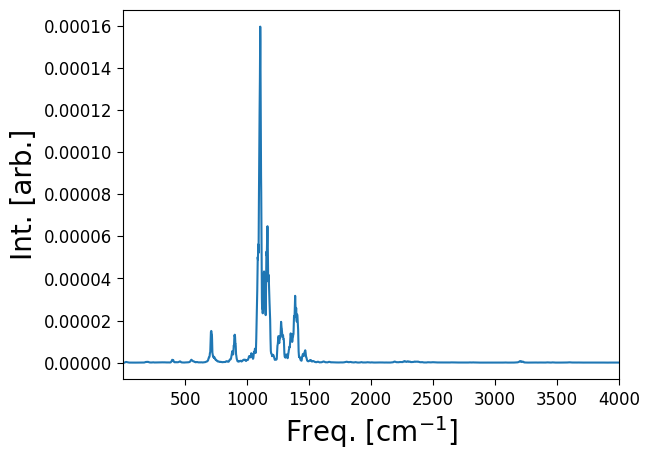

In [133]:
plt.plot(freq, spectra*0.01)
plt.xlim(1, 4000)
plt.ylabel("Int. [arb.]", fontsize=20)
plt.xlabel("Freq. [cm$^{-1}$]", fontsize=20)